In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-fer/test/fearful/im292.png
/kaggle/input/emotion-detection-fer/test/fearful/im1022.png
/kaggle/input/emotion-detection-fer/test/fearful/im633.png
/kaggle/input/emotion-detection-fer/test/fearful/im934.png
/kaggle/input/emotion-detection-fer/test/fearful/im927.png
/kaggle/input/emotion-detection-fer/test/fearful/im966.png
/kaggle/input/emotion-detection-fer/test/fearful/im662.png
/kaggle/input/emotion-detection-fer/test/fearful/im648.png
/kaggle/input/emotion-detection-fer/test/fearful/im178.png
/kaggle/input/emotion-detection-fer/test/fearful/im817.png
/kaggle/input/emotion-detection-fer/test/fearful/im308.png
/kaggle/input/emotion-detection-fer/test/fearful/im623.png
/kaggle/input/emotion-detection-fer/test/fearful/im651.png
/kaggle/input/emotion-detection-fer/test/fearful/im72.png
/kaggle/input/emotion-detection-fer/test/fearful/im229.png
/kaggle/input/emotion-detection-fer/test/fearful/im444.png
/kaggle/input/emotion-detection-fer/test/fearful/im415.p

In [2]:
# libraries for system
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



#import DL libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-02-04 14:45:22.251421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 14:45:22.251538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 14:45:22.385049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [3]:
train_dir = '/kaggle/input/emotion-detection-fer/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,/kaggle/input/emotion-detection-fer/train/fear...,fearful
1,/kaggle/input/emotion-detection-fer/train/fear...,fearful
2,/kaggle/input/emotion-detection-fer/train/fear...,fearful
3,/kaggle/input/emotion-detection-fer/train/fear...,fearful
4,/kaggle/input/emotion-detection-fer/train/fear...,fearful
...,...,...
28704,/kaggle/input/emotion-detection-fer/train/happ...,happy
28705,/kaggle/input/emotion-detection-fer/train/happ...,happy
28706,/kaggle/input/emotion-detection-fer/train/happ...,happy
28707,/kaggle/input/emotion-detection-fer/train/happ...,happy


In [5]:
# Generate  test data paths with labels
test_dir = '/kaggle/input/emotion-detection-fer/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
test_df

,filepaths,labels
0,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
1,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
2,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
3,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
4,/kaggle/input/emotion-detection-fer/test/fearf...,fearful
...,...,...
7173,/kaggle/input/emotion-detection-fer/test/happy...,happy
7174,/kaggle/input/emotion-detection-fer/test/happy...,happy
7175,/kaggle/input/emotion-detection-fer/test/happy...,happy
7176,/kaggle/input/emotion-detection-fer/test/happy...,happy


In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 28709 validated image filenames belonging to 7 classes.
Found 4306 validated image filenames belonging to 7 classes.
Found 2872 validated image filenames belonging to 7 classes.


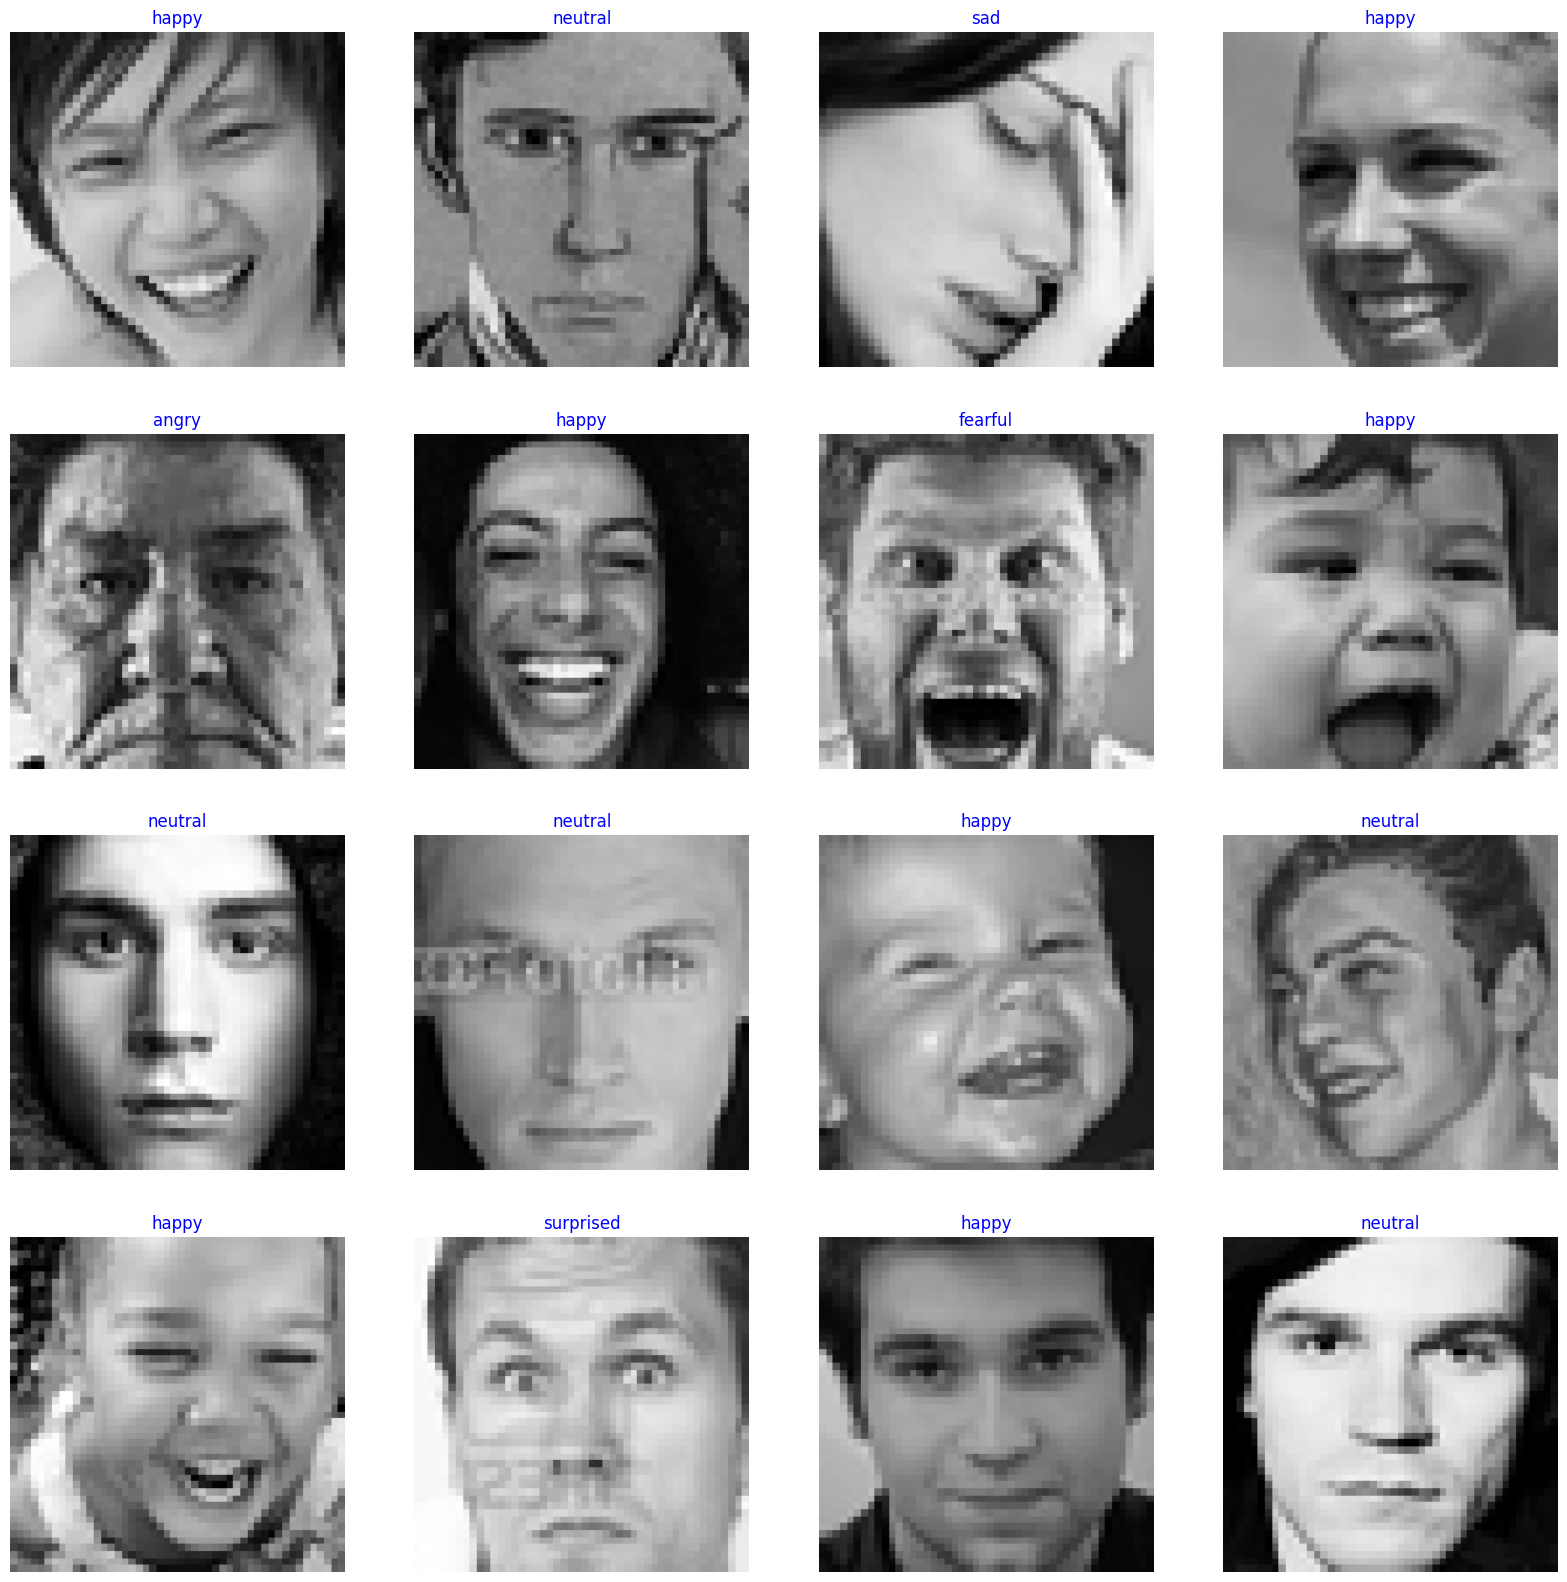

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [10]:
#Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

258076736/258076736 [==============================] - 11s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                      

In [11]:
batch_size = 20   # set batch size for training
epochs =  10  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)




Epoch 1/10


2024-02-04 14:47:23.583554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707058054.921563      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1795/1795 [==============================] - 1174s 587ms/step - loss: 4.8114 - accuracy: 0.5023 - val_loss: 2.0814 - val_accuracy: 0.6126
Epoch 2/10
1795/1795 [==============================] - 1054s 587ms/step - loss: 1.6545 - accuracy: 0.6054 - val_loss: 1.3447 - val_accuracy: 0.6294
Epoch 3/10
1795/1795 [==============================] - 1052s 586ms/step - loss: 1.3121 - accuracy: 0.6373 - val_loss: 1.3424 - val_accuracy: 0.6108
Epoch 4/10
1795/1795 [==============================] - 1048s 584ms/step - loss: 1.1807 - accuracy: 0.6715 - val_loss: 1.1961 - val_accuracy: 0.6575
Epoch 5/10
1795/1795 [==============================] - 1048s 584ms/step - loss: 1.0242 - accuracy: 0.7291 - val_loss: 1.2339 - val_accuracy: 0.6549
Epoch 6/10
1795/1795 [==============================] - 1055s 588ms/step - loss: 0.8705 - accuracy: 0.7863 - val_loss: 1.1419 - val_accuracy: 0.6797
Epoch 7/10
1795/1795 [==============================] - 1050s 585ms/step - loss: 0.7113 - accuracy: 0.8406 - val_loss

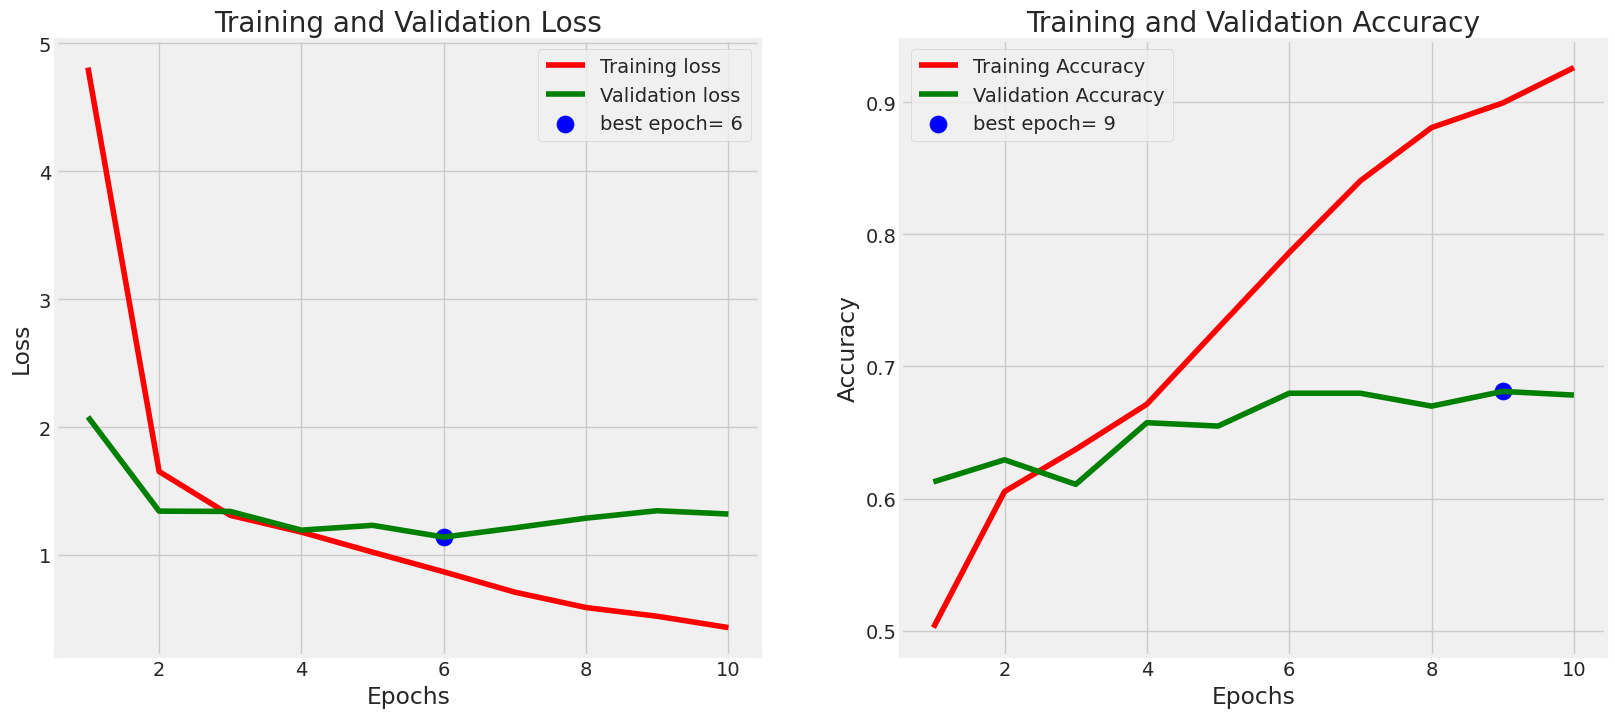

In [12]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

359/359 [==============================] - 23s 63ms/step - loss: 1.3558 - accuracy: 0.6720
Train Loss:  0.30760982632637024
Train Accuracy:  0.9641364812850952
--------------------
Validation Loss:  1.3222047090530396
Validation Accuracy:  0.6783557534217834
--------------------
Test Loss:  1.3557922840118408
Test Accuracy:  0.6720055937767029


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

confusion matrix and classification report

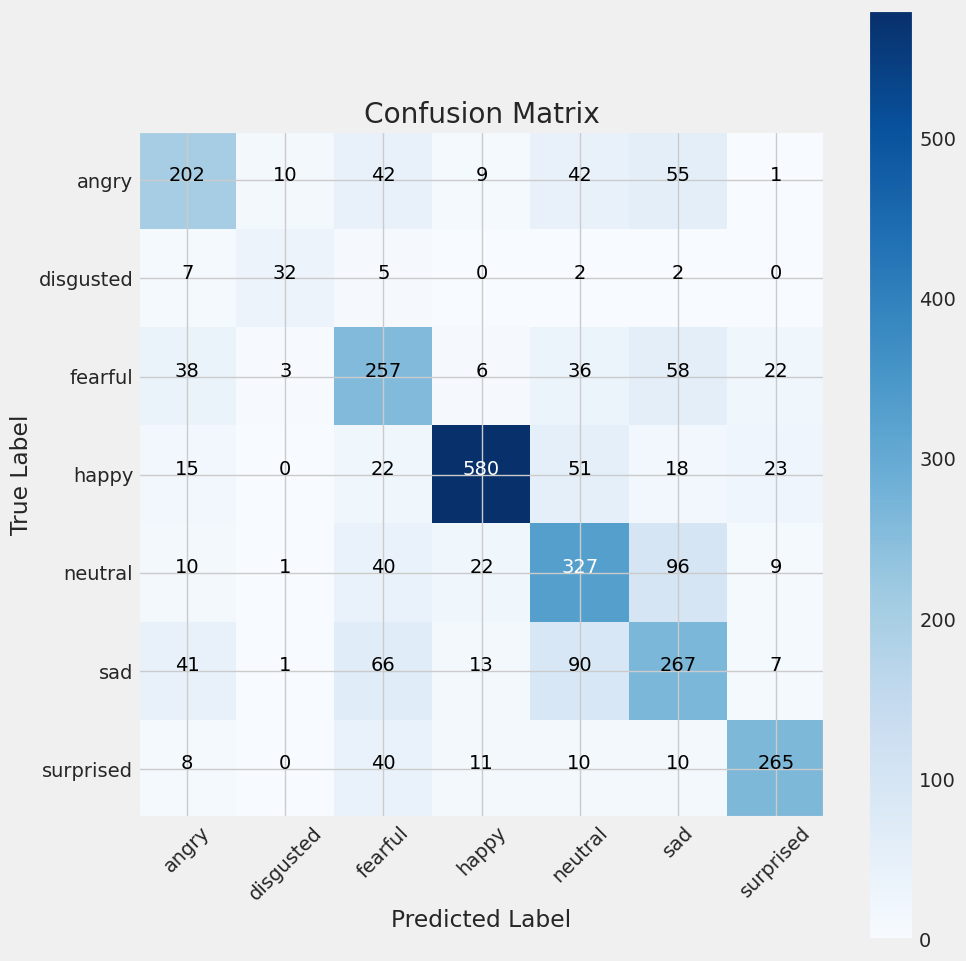

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.63      0.56      0.59       361
   disgusted       0.68      0.67      0.67        48
     fearful       0.54      0.61      0.58       420
       happy       0.90      0.82      0.86       709
     neutral       0.59      0.65      0.62       505
         sad       0.53      0.55      0.54       485
   surprised       0.81      0.77      0.79       344

    accuracy                           0.67      2872
   macro avg       0.67      0.66      0.66      2872
weighted avg       0.68      0.67      0.68      2872



saving the model and load it to predict

In [17]:
model.save("model.h5")

In [18]:
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [19]:
image_path = '/kaggle/input/emotion-detection-fer/test/happy/im1002.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 6s 6s/step
happy


In [20]:
image_path2 = '/kaggle/input/emotion-detection-fer/test/surprised/im1.png'
image = Image.open(image_path2)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 59ms/step
surprised
